# Spending on Healthcare: The Impact on Quality and Outcomes

# Abstract

This project explores whether increased healthcare expenditure per capita is positively correlated with lower preventable deaths, shorter hospital stays, greater access to medical technology, and higher life expectancies at birth across OECD countries from 2000 to 2019. Our hypothesis was that greater healthcare spending would be positively correlated with our chosen categories across countries. 

To test this hypothesis, I compiled and standardized multiple datasets from the OECD, ensuring consistency across countries and years by tidying data through a custom preprocessing function. Key steps included cleaning column names, filtering for relevant variables, converting data to numeric formats, and restricting the analysis to the years 2000–2019 to avoid confounding effects from the COVID-19 pandemic. To analyze the relationship between healthcare expenditure and healthcare quality, I developed a ranking system for each considered variable—preventable deaths, hospital stay lengths, medical technology access, and life expectancy—assigning lower ranks to better performance (e.g., a rank of 1 for the best). The function calculated the mean and standard deviation for each variable to determine appropriate weights for a weighted average. I then aggregated these rankings into a composite score for each country, reflecting overall healthcare quality. After cleaning and finalizing the rankings, I examined the correlation between a country's healthcare quality ranking and its healthcare expenditure rankings, both as a percentage of GDP and per capita.  

Despite prior research indicating a positive correlation between expenditure and healthcare quality, our findings did not support the hypothesis. Statistical analysis revealed no significant relationship between healthcare expenditure, whether measured as a percentage of GDP or per capita, and the metrics of healthcare quality defined in this study. This includes preventable deaths, average hospital stay lengths, access to medical technology, and life expectancies. In line with previous studies the results suggest that while financial resources are necessary for a functioning healthcare system, healthcare expeniditure alone is not a reliable predictor of healthcare quality. 

# Research Question

How does healthcare quality in terms of preventable deaths, average hospital stay, access to medical technology, and life expectancies correlate with healthcare expenditure per capita by each OECD (Organization for Economic Cooperation and Development) country from 2000-2019?



## Background and Prior Work

Healthcare spending is a heavily debated topic in politics, but can we learn from the outcomes of countries' different healthcare policies around the world? I aim to research the correlation between healthcare expenditure per capita and quality of received care among developed countries with public healthcare systems. Here, I define quality of care as a collection of the proportion of preventable deaths, surgery wait times, life expectancies, and access to medical technology. The amount of financial resources allocated to healthcare in various individual countries have been found to impact the overall quality of the healthcare provided. How healthcare outcomes correlate with the amount of healthcare expenditure has gotten mixed results, although many results find a positive correlation, especially in OECD countries <sup> 1 </sup>. OECD countries are a collection of countries with market-based economies that work together to create policies for sustainable growth. 

The previous works differ in the exact results because of different metrics used. However, even though there may be a mild positive correlation between healthcare expenditure and overall satisfaction in most versions, a lot of results also indicate that there is no clear positive or negative correlation between healthcare expenditure and quality of care received <sup> 2 </sup> -- especially when the spending is not efficiently utilized <sup> 3 </sup>. The study published by The Annals of Internal Medicine is a synthesis of several prior studies to determine if there is an association between healthcare cost and quality in the United States <sup> 2 </sup>. It observes studies over the years of 1990-2012, concluding that the association was relatively clinically insignificant. This is one of the reasons why I decided to focus solely on countries with public healthcare systems, as government spending has a larger direct impact on the healthcare system as a whole.

1. ^ Anwar, Asim, et al. (22 Mar. 2023) Government Health Expenditures and Health Outcome Nexus: A Study on OECD Countries. Frontiers, Frontiers. www.frontiersin.org/journals/public-health/articles/10.3389/fpubh.2023.1123759/full.
2. ^ Hussey, Peter S, et al. (1 Jan. 2013) The Association Between Health Care Quality and Cost: A Systematic Review ACP Journals. Annals of Internal Medicine. www.acpjournals.org/doi/10.7326/0003-4819-158-1-201301010-00006?url_ver=Z39.88-2003&rfr_id=ori:rid:crossref.org&rfr_dat=cr_pub%20%200pubmed.
3. ^ Fowler, Floyd J, et al. (28 May 2008) Relationship between Regional per Capita Medicare Expenditures and Patient Perceptions of Quality of Care. JAMA, JAMA Network. www.jamanetwork.com/journals/jama/fullarticle/181980.

# Hypothesis


Increased healthcare expenditure per capita is positively correlated with lower preventable deaths, shorter hospital stay lengths, greater medical technology access, and higher life expectancies from birth across countries.

**Explanation:**

In our background analysis, I found that a small portion of previously conducted studies indicated that greater healthcare expenditure correlates to increased healthcare quality. As such, I expect similarly positive results since our definition of healthcare quality includes variables similar to those analyzed across previous studies. I believe this is further increased by the fact that I have carefully narrowed our scope to OECD countries with public healthcare.

# Data

##  - Data overview

All information for each dataset can be found under their title.

Each dataset has at least 4 variables: 
  1. country
  2. code (aka country code - for use when merging later)
  3. year (spanning 2000-2019)
  4. a variable important to our analysis

## - Cleaning and Importing Datasets

In [2]:
# Imports
import pandas as pd
from analysis import analyze
from tidy import tidy
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from scipy.stats import linregress

# To silence deprecation warnings on the graphs regarding new pandas version
import warnings;
warnings.filterwarnings('ignore')

Since several of our datasets were from the same OECD information website, the datasets often had the same general layout when downloaded. Therefore, I created a function `tidy` that takes in some input parameters specific to a given dataset and runs a common set of steps on that dataframe in order to tidy it. This way, I wasn't copy pasting the code and modifying it a bunch. Our goals in tidying were to make all column names lowercase and reduce the columns in every dataset to just have country, country code, year, and the variable that is being analyzed. This way, they could all be merged into one large dataframe later on. Furthermore, I wanted the year and variable columns to be numeric so they could be easily analyzed. Then, I wanted to make sure the years were in the range [2000, 2019] for all datasets, as I wanted a relatively large number of years that were likely to have data. I avoided 2020 and onward data because COVID-19 brought far more confounding variables and changes in healthcare policies that I felt would make the analysis far less valuable and more confusing. In tidying, I also wanted to sort dataframes by country and year to make them easier to read and analyze.

In [3]:
def drop_cols_with_proportion_na(df: pd.DataFrame, proportion: float = 0.9) -> pd.DataFrame:
    """
    Drop any columns in the dataframe that are some proportion or more of NA values
    Parameters:
        df - dataframe to drop columns from
        proportion - minimum proportion (between 0 and 1) of NA values in a column for that column to be dropped
    Returns:
        updated DataFrame
    """
    drop_cols = []
    # collect all columns that have >= proportion NA values
    for col in df.columns:
        proportion_na = df[col].isna().mean()
        # Handle if duplicate column wasn't dropped - ex: 'SEX' and 'sex' columns are both 'sex' after tidying
        if not isinstance(proportion_na, float):
            raise ValueError(f"after renaming columns, col '{col}' appears more than once in the dataframe. Please add one of them to the drop_columns when calling tidy().")
        if proportion_na >= proportion:
            drop_cols.append(col)
    # drop columns
    df = df.drop(columns=drop_cols)
    return df


def tidy_informational(df: pd.DataFrame, og_country_column: str = "Reference area", 
                       og_country_code_column: str = "REF_AREA", 
                       og_year_column: str = "TIME_PERIOD",
                       drop_columns:list[str]=None) -> pd.DataFrame:

    # drop unneeded columns
    if drop_columns is None:
        drop_columns = ["STRUCTURE", "STRUCTURE_ID", "STRUCTURE_NAME", "ACTION", "FREQ", "MEASURE",
                        "UNIT_MEASURE", "FINANCING_SCHEME", "FINANCING_SCHEME_REV", "FUNCTION",
                        "MODE_PROVISION", "PROVIDER", "FACTOR_PROVISION", "ASSET_TYPE",
                        "PRICE_BASE", "Time period", "Observation value", "Base period",
                        "CURRENCY", "UNIT_MULT", "DECIMALS", "Decimals"]
    df = df.drop(columns=drop_columns)
    # rename unclear columns
    rename_dict = {og_year_column: "year",
                   og_country_column: "country",
                   og_country_code_column: "code"}
    df = df.rename(columns=rename_dict)

    # drop all rows not in desried time frame
    max_year = 2019
    min_year = 2000
    df = df[(df["year"] <= max_year) & (df["year"] >= min_year)]

    # rename columns to be lowercase and replace spaces with underscores
    all_columns = list(df.columns)
    lower_columns = []
    for column in all_columns:
        lower_columns.append(column.lower().replace(" ", "_"))
    rename_dict = dict(zip(all_columns, lower_columns))
    df = df.rename(columns=rename_dict)

    # drop columns with at least 90% NA values
    df = drop_cols_with_proportion_na(df, 0.9)

    # drop columns that have the not applicable in them
    not_app_columns = df.columns[(df == "Not applicable").all()]
    df = df.drop(columns=not_app_columns)

    # drop columns that have the not application in them
    not_application_columns = df.columns[(df == "Not application").all()]
    df = df.drop(columns=not_application_columns)

    # checking that function successfully changed column names
    assert "country" in df.columns, "no country column found, orginal dataframe columns named differently than expected"
    assert "year" in df.columns, "no year column found, orginal dataframe columns named differently than expected"

    return df


def tidy_numerical(df):
    # specify non numerical columns to keep - country, year, and code are all vital
    keep_columns = ["country", "year", "code"]
    # get a list of numerical columns
    numerical_columns = df.select_dtypes(include=["int64", "float64"]).columns
    for column in numerical_columns:
        if column not in keep_columns:
            keep_columns.append(column)
    # drop all other non numerical columns to create a tidied dataframe
    drop_columns = [col for col in df.columns if col not in keep_columns]
    df = df.drop(columns=drop_columns)
    return df

def sort_by_country_and_year(df:pd.DataFrame) -> pd.DataFrame:
    return df.sort_values(['code', 'year'], ascending=[True, True])

def tidy(
        df: pd.DataFrame, df_title: str, new_data_cols_map: dict[str],
        og_country_column: str = "Reference area", og_year_column: str = "TIME_PERIOD",
        drop_columns: list[str] = None, og_country_code_column:str ="REF_AREA",) -> pd.DataFrame:
    """
    Tidy a dataframe in 2 steps, saving along the way:
        1. get it to an informational state and save in informational_datasets: 
            - drop useless columns
            - rename remaining columns
        2. get it to a tidy state and save in cleaned_datasets:
            - just containing an index, country, year, and data column(s)

    Parameters:
        - df: original dataframe
        - df_title: name of the dataframe - what the df represents (for saving in different files)
            - ex: "healthcare_expenditure_per_capita"
        - new_data_cols_map: dict mapping old name to new for the data column(s) in the df 
            - ex: {"OBSERVED VALUE":"healthcare_expenditure_per_capita"}
        - og_country_column: name of the column in the dataframe that contains the countries
        - og_year_name: name of the column in the dataframe that contains the years
        - drop_columns: a list of unneccessary columns that should be dropped
            - should not contain columns that would be put in the informational_dataset

    Returns:
        An updated, tidied dataframe

    Side Effects:
        Saves dfs to informational_datasets and cleaned_datasets
    """
    df_title = df_title.replace(" ", '_').lower()
    new_data_cols_map = {key: value.replace(" ", "_").lower()
                         for key, value in new_data_cols_map.items()}
    # rename important columns
    df = df.rename(columns=new_data_cols_map)
    df = tidy_informational(df,
                            og_country_column=og_country_column, 
                            og_year_column=og_year_column,
                            og_country_code_column=og_country_code_column, 
                            drop_columns=drop_columns)
    # save the dataframe before dropping all non-numerical columns in case I need to go back and understand any other context to the file
    df.to_csv(f'informational_datasets/{df_title}.csv', index=False)
    df = tidy_numerical(df)
    df = sort_by_country_and_year(df)
    df.to_csv(f'cleaned_datasets/{df_title}.csv', index=False)
    df = df.reset_index(drop=True)
    return df


By calling these three functions I am able to standardize the cleaning of datasets. There are three functions one to drop columns with more then 90% null values called drop_cols_with_proportion_na. Then I further clean the datasets and save them to an informational dataset the retains useful contextual information, this function is called tidy informational. Finally, I call Tidy which finalizes the cleaning process into just imporant information for our final merge. 

 ### 1. Healthcare Expenditure per Capita by Country 

- Dataset Name: Current health expenditure per capita (current US$)
- Link to the dataset: https://data.worldbank.org/indicator/SH.XPD.CHEX.PC.CD
- Number of observations: 5320 (271 before data wrangling)
- Number of variables: 4 (69 before data wrangling)

In [4]:
def healthcare_expenditure_worldbank():
    df = pd.read_csv("original_datasets/healthcare_expenditure_worldbank.csv")
    df = df.rename(columns=df.iloc[3]).iloc[4:]
    #drop columns not needed and only years from 2000 to 2019
    columns_to_keep = ['Country Name', 'Country Code'] + \
                  [col for col in df.columns if isinstance(col, float) and col >= 2000.0 and col<=2019]
    df_filtered = df[columns_to_keep]
    
    #change the orientation of the dataframe and add years as observations instead of variables
    df_long = pd.melt(df_filtered, 
                  id_vars=['Country Name', 'Country Code'], 
                  var_name='Year', 
                  value_name='Value')
    
    # convert 'year' column from float to integer
    df_long['Year'] = df_long['Year'].astype(int)
    # change column names
    df_long.columns = ['country', 'code', 'year', 'expenditure_per_capita']
    # sort df
    df_long = df_long.sort_values(['code', 'year'], ascending=[True, True])
    df_long = df_long.reset_index(drop=True)
    # save df
    df_long.to_csv("cleaned_datasets/healthcare_expenditure_worldbank.csv", index=False)

# tidy the data - commented out since it only needed to run once to tidy the data
# healthcare_expenditure_worldbank()
# load the data
health_exp = pd.read_csv("cleaned_datasets/healthcare_expenditure_worldbank.csv")
health_exp

,country,code,year,expenditure_per_capita
0,Aruba,ABW,2000,NaN
1,Aruba,ABW,2001,NaN
2,Aruba,ABW,2002,NaN
3,Aruba,ABW,2003,NaN
4,Aruba,ABW,2004,NaN
...,...,...,...,...
5315,Zimbabwe,ZWE,2015,105.098030
5316,Zimbabwe,ZWE,2016,106.189697
5317,Zimbabwe,ZWE,2017,92.254288
5318,Zimbabwe,ZWE,2018,114.632950


The above dataset from the World Bank database that includes Healthcare expenditure per capita by country from 1960 to now including 271 countries. The dataset originally had years as its columns and had unnecessary columns such as "Indicator Name" which only had one value (healthcare expenditure per capita). I only limited the dataset to include only data from 2000 to 2019 like I did in all the other datasets and specifically for the World Bank data I needed to use the "melt" function from pandas so the years would appear as observations instead of variables.

### 2. Life Expectancy by Country 

- Dataset Name: Life expectancy at birth, total (years) - World Bank
- Link to the dataset: https://data.worldbank.org/indicator/SP.DYN.LE00.IN?locations=1W
- Number of observations: 5320 (271 before data wrangling)
- Number of variables: 4 (69 before data wrangling)

In [5]:
def life_expectancy_worldbank():
    df = pd.read_csv("original_datasets/life_expectancy.csv")
    df = df.rename(columns=df.iloc[3]).iloc[4:]
    #drop columns not needed and only years from 2000 to 2019
    columns_to_keep = ['Country Name', 'Country Code'] + \
                   [col for col in df.columns if isinstance(col, float) and col >= 2000.0 and col<=2019]
    df_filtered = df[columns_to_keep]
    
    #change the orientation of the dataframe and add years as observations instead of variables
    df_long = pd.melt(df_filtered,
                  id_vars=['Country Name', 'Country Code'],
                  var_name='Year',
                  value_name='Value')
    
    # convert 'year' column from float to integer
    df_long['Year'] = df_long['Year'].astype(int)
    # change column names
    df_long.columns = ['country', 'code', 'year', 'life_expectancy']
    # sort dataframe
    df_long = df_long.sort_values(['code', 'year'], ascending=[True, True])
    df_long = df_long.reset_index(drop=True)
    df = df_long
    df.to_csv('cleaned_datasets/life_expectancy.csv', index=False)
    df_title = 'life_expectancy'
    analyze(df, df_title)
    print("Dataframe:", df, sep="\n")

# tidy the data - commented out since it only needed to run once to tidy the data
# life_expectancy_worldbank()
#load the data
life_expec = pd.read_csv("cleaned_datasets/life_expectancy.csv")
life_expec

,country,code,year,life_expectancy
0,Aruba,ABW,2000,73.569
1,Aruba,ABW,2001,73.647
2,Aruba,ABW,2002,73.726
3,Aruba,ABW,2003,73.752
4,Aruba,ABW,2004,73.576
...,...,...,...,...
5315,Zimbabwe,ZWE,2015,59.591
5316,Zimbabwe,ZWE,2016,60.306
5317,Zimbabwe,ZWE,2017,60.709
5318,Zimbabwe,ZWE,2018,61.414


The above dataset from the World Bank database as well and it includes Life Expectancy at birth (in years) by country from 1960 to now including 271 countries like our first data. I used mostly the same process as I did in the first dataset to clean this data (using melt function, dropping unnecessary columns, etc.) because the two datasets are very similar. The only difference between the two was that the value for #2 was life expectancy instead of healthcare expenditure per capita.

### 3. Avoidable Mortality Rates by Country

- Dataset Name: Avoidable Mortality
- Link to the dataset: https://data-explorer.oecd.org/vis?fs[0]=T%2Co&pg=20&fc=Topic&snb=80&vw=ov&df[ds]=dsDisseminateFinalDMZ&df[id]=DSD_HEALTH_STAT%2540DF_AM&df[ag]=OECD.ELS.HD&df[vs]=1.0&dq=.A...._T.......&pd=2%2C0%2C1%2C0%2C%25%2C2%2CC&to[TIME_PERIOD]=false 
- Number of observations: 13770
- Number of variables: 4

In [6]:
def avoidable_mortality():
    read_file = "original_datasets/avoidable_mortality.csv"
    df = pd.read_csv(read_file)
    df_title = "avoidable_mortality"
    unnecessary_cols = ["STRUCTURE", "STRUCTURE_ID", "STRUCTURE_NAME", "ACTION", "FREQ", "MEASURE",
                        "UNIT_MEASURE", "Time period", "Observation value", "UNIT_MULT",
                        "DECIMALS", "Decimals", "AGE", "SOCIO_ECON_STATUS", "DEATH_CAUSE",
                        "CALC_METHODOLOGY", "GESTATION_THRESHOLD", "HEALTH_STATUS", "DISEASE",
                        "CANCER_SITE", "Observation value", "OBS_STATUS2", "SEX",
                        "OBS_STATUS3"]
    new_data_cols_rename_dict = {
        "OBS_VALUE": "avoidable_deaths"
    }
    df = tidy(df, df_title=df_title, new_data_cols_map=new_data_cols_rename_dict,
              drop_columns=unnecessary_cols)
    analyze(df, df_title)
    print(df)


# tidy the data - commented out since it only needed to run once to tidy the data
# avoidable_mortality()
# load the data
av_mortality = pd.read_csv("cleaned_datasets/avoidable_mortality.csv")
av_mortality

,code,country,year,avoidable_deaths
0,ARG,Argentina,2000,135.9
1,ARG,Argentina,2000,473.9
2,ARG,Argentina,2000,45802.0
3,ARG,Argentina,2000,97487.0
4,ARG,Argentina,2000,91.3
...,...,...,...,...
15187,ZAF,South Africa,2018,50267.5
15188,ZAF,South Africa,2018,582.9
15189,ZAF,South Africa,2018,221.6
15190,ZAF,South Africa,2018,238073.0


The above dataset displays data from OECD Data Explorer and shows avoidable mortality by country stored as floats. The dataset has avoidable mortality as defined by deaths that could have been avoided given proper measures and healthcare access. This dataset needed cleaning to only include the dates I am analyzing (2000-2019).

### 4. Average Hospital Stay by Country 

- Dataset Name: Hospital average length of stay by diagnostic categories
- Link to the dataset: https://data-explorer.oecd.org/vis?lc=en&df[ds]=dsDisseminateFinalDMZ&df[id]=DSD_HEALTH_PROC%2540DF_HOSP_AV_LENGTH&df[ag]=OECD.ELS.HD&dq=.....DICDA100............&pd=%25%2C2%2CC&to[TIME_PERIOD]=false&vw=ov 
- Number of observations: 84558
- Number of variables: 4

In [7]:
def hospital_stay_length():
    df = pd.read_csv("original_datasets/hospital_stay_length.csv")
    df_title = "hospital_stay_length"
    unnecessary_cols = ["STRUCTURE", "STRUCTURE_ID", "STRUCTURE_NAME", "ACTION", "MEASURE",
                        "UNIT_MEASURE", "Time period", "Observation value", "UNIT_MULT",
                        "DECIMALS", "Decimals", "AGE", "DISEASE", "DIAGNOSTIC_TYPE", "PROVIDER",
                        "CANCER_SITE", "Observation value", "OBS_STATUS2", "SEX", "FUNCTION", 
                        "MODE_PROVISION", "CARE_TYPE", "HEALTH_FACILITY", "WAITING_TIME",
                        "CONSULTATION_TYPE", "OBS_STATUS", "OBS_STATUS2", "OBS_STATUS3", 
                        "MEDICAL_PROCEDURE", "OCCUPATION"]
    new_data_cols_rename_dict = {
        "OBS_VALUE": "hospital_stay_length"
    }
    df = tidy(df, df_title=df_title, new_data_cols_map=new_data_cols_rename_dict,
              drop_columns=unnecessary_cols)
    analyze(df, df_title)
    print(df)

# tidy the data - commented out since it only needed to run once to tidy the data
# hospital_stay_length()
# load the data
len_stay = pd.read_csv("cleaned_datasets/hospital_stay_length.csv")
len_stay

,code,country,year,hospital_stay_length
0,AUS,Australia,2000,5.2
1,AUS,Australia,2000,7.9
2,AUS,Australia,2000,4.2
3,AUS,Australia,2000,4.6
4,AUS,Australia,2000,6.1
...,...,...,...,...
93189,USA,United States,2010,4.3
93190,USA,United States,2010,4.7
93191,USA,United States,2010,4.9
93192,USA,United States,2010,4.3


The above dataset shows data from OECD Data Explorer and shows the average length of stay by diagnostic categories. The average length of stay is calculated in this dataset by dividing the number of "bed-days" by number of discharges in the given year. This dataset needed to be cleaned to include our dates of interest (2000-2019) and drop excess columns to see the length of stay.

### 5. Health Expenditure and Financing


- Dataset Name: Health expenditure and financing
- Link to the dataset: [https://data-explorer.oecd.org/vis?df[ds]=dsDisseminateFinalDMZ&df[id]=DSD_SHA%40DF_SHA&df[ag]=OECD.ELS.HD&df[vs]=1.0&dq=.A.EXP_HEALTH.PT_B1GQ._T.._T.._T..._Z&pd=2000%2C2009&to[TIME_PERIOD]=false&vw=tb](https://data-explorer.oecd.org/vis?df[ds]=dsDisseminateFinalDMZ&df[id]=DSD_SHA%40DF_SHA&df[ag]=OECD.ELS.HD&df[vs]=1.0&dq=.A.EXP_HEALTH.PT_B1GQ._T.._T.._T..._Z&pd=2000%2C2009&to[TIME_PERIOD]=false&vw=tb)
- Number of observations: 984
- Number of variables: 4

In [8]:
def health_expenditure_as_percent_of_gdp():
    read_file = "original_datasets/filtered_health_expenditure_as_percent_gdp.csv"
    # cols 38 - 41 are NA for the first large chunk --> pandas must be told their type to not mix up types while reading in df in chunks to save memory
    df = pd.read_csv(read_file, dtype={i: object for i in range(38,42)})
    # most of these are duplicate short-version columns
    unnecessary_cols = [
        'STRUCTURE', 'STRUCTURE_ID', 'STRUCTURE_NAME', 'ACTION', 'MEASURE', 'UNIT_MEASURE', 'FREQ',
        'FINANCING_SCHEME', 'PRICE_BASE', 'CURRENCY', 'BASE_PER', 'FUNCTION', 'MODE_PROVISION',
        'FACTOR_PROVISION', 'ASSET_TYPE', 'Time period', 'Observation value', 'DECIMALS',
        'Decimals', 'OBS_STATUS', 'OBS_STATUS2', 'OBS_STATUS3', 'Unit multiplier', 'UNIT_MULT',
        'MODE_PROVISION'
    ]
    data_cols_rename_dict = {
        'OBS_VALUE': 'health_expenditure_as_percent_gdp'
    }
    df_title = "filtered_health_expenditure_as_percent_gdp"
    country_col = "Reference area"
    
    # tidy and analyze dataframe
    df = tidy(df, df_title, data_cols_rename_dict, og_country_column=country_col,
              og_year_column="TIME_PERIOD", drop_columns=unnecessary_cols)
    analyze(df, df_title)
    print("Dataframe:", df, sep="\n")

# tidy the data - commented out since it only needed to run once to tidy the data
# health_expenditure_as_percent_of_gdp()
# load the data
expenditure_p_gdp = pd.read_csv("cleaned_datasets/filtered_health_expenditure_as_percent_gdp.csv")
expenditure_p_gdp

,code,country,year,health_expenditure_as_percent_gdp
0,ARG,Argentina,2000,8.220
1,ARG,Argentina,2001,8.372
2,ARG,Argentina,2002,7.393
3,ARG,Argentina,2003,6.895
4,ARG,Argentina,2004,7.229
...,...,...,...,...
979,ZAF,South Africa,2015,8.053
980,ZAF,South Africa,2016,8.080
981,ZAF,South Africa,2017,7.977
982,ZAF,South Africa,2018,8.077


The above is a dataset from OECD Data Explorer that contains the metric of the ratio of the GDP that each country spends on its healthcare. This is a float between between 0 and 100 (although no country has near 100). I limited the data from 2000-2019, and used the same tidy() function I wrote that was used in datasests 3 and onward (for all the OECD Data Explorer datasets). This function drops unnecessary columns, renames them to lowercase with no spaces, sorts the dataframe by country then year, and saves in two steps: one as an informational dataframe (with text-based columns), and one with only country, country code, year, and numerical columns. 

### 6. Medical Technological Availability

  - Dataset Name: Medical technology availability
  - Link to the dataset: [https://data-explorer.oecd.org/vis?lc=en&df[ds]=dsDisseminateFinalDMZ&df[id]=DSD_HEALTH_REAC_HOSP%40DF_MED_TECH&df[ag]=OECD.ELS.HD&dq=..10P6HB......_T&pd=%2C&to[TIME_PERIOD]=false&vw=tb](https://data-explorer.oecd.org/vis?lc=en&df[ds]=dsDisseminateFinalDMZ&df[id]=DSD_HEALTH_REAC_HOSP%40DF_MED_TECH&df[ag]=OECD.ELS.HD&dq=..10P6HB......_T&pd=%2C&to[TIME_PERIOD]=false&vw=tb)
  - Number of observations: 16492
  - Number of variables: 4

In [9]:
def medical_tech_availability():
    read_file = "original_datasets/medical_tech_availability.csv"
    df = pd.read_csv(read_file)
    # most of these are duplicate short-version columns
    unnecessary_cols = [
        'STRUCTURE', 'STRUCTURE_ID', 'STRUCTURE_NAME', 'ACTION', 'MEASURE', 'UNIT_MEASURE',
        'STATISTICAL_OPERATION', 'OWNERSHIP_TYPE', 'HEALTH_FUNCTION', 'CARE_TYPE',
        'HEALTH_CARE_PROVIDER', 'Time period', 'Observation value', 'DECIMALS', 'Decimals',
        'OBS_STATUS', 'OBS_STATUS2', 'OBS_STATUS3', 'UNIT_MULT', 'REF_YEAR_PRICE'
    ]
    data_cols_rename_dict = {
        'OBS_VALUE': 'med_tech_availability_p_mil_ppl'
    }
    df_title = "medical_tech_availability"
    df = tidy(df, df_title,
              data_cols_rename_dict, drop_columns=unnecessary_cols)
    analyze(df, df_title)
    print("Dataframe:", df, sep="\n")

# tidy the data - commented out since it only needed to run once to tidy the data
# medical_tech_availability()
# load the data
med_tech = pd.read_csv("cleaned_datasets/medical_tech_availability.csv")
med_tech

,code,country,year,med_tech_availability_p_mil_ppl
0,AUS,Australia,2000,99.00
1,AUS,Australia,2000,67.00
2,AUS,Australia,2000,500.00
3,AUS,Australia,2000,5.20
4,AUS,Australia,2000,26.28
...,...,...,...,...
16487,USA,United States,2019,16.54
16488,USA,United States,2019,63.81
16489,USA,United States,2019,48.76
16490,USA,United States,2019,22.36


The above is a dataset from OECD Data Explorer that contains the availability of different medical technologies in each country per 1,000,000 inhabitants. These technologies are the following (from OECD Data Explorer): "computed tomography scanners, magnetic resonance imaging units, positron emission tomography (PET) scanners, gamma cameras, mammographs, and radiation therapy equipment". The datatype of this value column is a float, and it is greater than or equal to 0. These values are a proxy for how well equipped a medical system is in relation to its population size.

## Merged Data

### Code 

In [10]:
def merge_data():
    # load all the necessary datasets

    health_exp = pd.read_csv("cleaned_datasets/healthcare_expenditure_worldbank.csv")
    med_tech = pd.read_csv("cleaned_datasets/medical_tech_availability.csv")
    expenditure_p_gdp = pd.read_csv("cleaned_datasets/filtered_health_expenditure_as_percent_gdp.csv")
    len_stay = pd.read_csv("cleaned_datasets/hospital_stay_length.csv")
    av_mortality = pd.read_csv("cleaned_datasets/avoidable_mortality.csv")
    life_expec = pd.read_csv("cleaned_datasets/life_expectancy.csv")

    # inner mege all the necessary datasets by (country, year)

    inner_merged = health_exp.merge(life_expec, on=['code', 'year'], how='inner') \
                    .merge(av_mortality, on=['code', 'year'], how='inner') \
                    .merge(len_stay, on=['code', 'year'], how='inner') \
                    .merge(expenditure_p_gdp, on=['code', 'year'], how='inner') \
                    .merge(med_tech, on=['code', 'year'], how='inner')
    inner_merged     


    #aggreagte hospital length stay and med tech availability by mean for each (country, year)

    aggregated = inner_merged.groupby(['code', 'year'], as_index=True).agg({
        'hospital_stay_length': 'mean',  
        'med_tech_availability_p_mil_ppl': 'mean',
        'expenditure_per_capita': 'first' ,       
        'life_expectancy': 'first' ,
        'avoidable_deaths': 'first' ,
        'health_expenditure_as_percent_gdp': 'first' 
    })

    #store the merged dataset in inner_final
    inner_final = aggregated.reset_index()

    #uncomment to turn it into a csv file
    #inner_final.to_csv('cleaned_datasets/inner_merged.csv', index=False)
    
    return inner_final


# inner_final = merge_data()


In [11]:
inner_final = pd.read_csv('cleaned_datasets/inner_merged.csv')
inner_final

,code,year,hospital_stay_length,med_tech_availability_p_mil_ppl,expenditure_per_capita,life_expectancy,avoidable_deaths,health_expenditure_as_percent_gdp
0,AUS,2000,7.494595,116.833333,1636.528564,79.234146,86.4,7.589
1,AUS,2001,6.535135,128.330000,1559.821289,79.634146,82.2,7.674
2,AUS,2002,6.466216,148.933333,1763.695679,79.936585,80.2,7.872
3,AUS,2003,6.220946,229.317500,2240.746094,80.239024,75.0,7.877
4,AUS,2004,6.329730,258.602500,2760.830811,80.490244,73.1,8.083
...,...,...,...,...,...,...,...,...
536,USA,2006,4.759028,3563.260000,6779.227539,77.687805,228.2,14.709
537,USA,2007,4.828873,3571.532143,7132.446777,77.987805,222.4,14.918
538,USA,2008,4.915942,2940.638571,7347.454590,78.039024,92.5,15.207
539,USA,2009,4.863043,6427.385000,7602.745605,78.390244,89.9,16.201


# Results

## Exploratory Data Analysis:

### 1. Descriptive Analysis 

Let's see what the descriptive statistics look like for our dataset:

In [12]:
def analyze(df: pd.DataFrame, cols_to_skip: list[str] = ["country", "code", "year"]):
    """
    Parameters:
        df - cleaned, tidy dataframe to analyze (columns should be variables, not individual years)
        df_title - what the dataframe represents (e.g. "Healthcare Expenditure Per Capita By Country")
        cols_to_skip (optional) - list of columns you don't want to analyze (e.g. ["country", "year"])
            - If you want to analyze all columns (not recommended), set cols_to_skip=[]
    Returns:
        None, but prints information about the dataframe
    """
    print("Dataframe description:")
    print(df.describe(), "\n")

    print("\nColumn Values Breakdown:")
    # Create a list of columns to analyze
    cols_to_analyze = [col for col in df.columns if col not in cols_to_skip]
    # Give value counts for each column
    for col in cols_to_analyze:
        print(f"Column {col}:")
        print(df[col].value_counts(), "\n")

    # analyze correlation between variable columns if more than one variable to analyze
    if len(cols_to_analyze) > 1:
        print("\nCorrelation Between Columns:")
        print(df[cols_to_analyze].corr(), "\n")

main_df = pd.read_csv('cleaned_datasets/main_df.csv')
analyze(main_df)

Dataframe description:
              year  hospital_stay_length  med_tech_availability_p_mil_ppl  \
count   504.000000            504.000000                       504.000000   
mean   2009.980159              8.192099                       206.489220   
std       5.443694              2.456980                       689.828123   
min    2000.000000              4.100000                         1.595000   
25%    2006.000000              6.807924                        21.888274   
50%    2010.000000              7.775429                        51.240139   
75%    2014.250000              8.882886                       160.752500   
max    2019.000000             19.439597                      6835.050000   

       expenditure_per_capita  life_expectancy  avoidable_deaths  \
count              504.000000       504.000000        504.000000   
mean              3125.713354        79.411419      14241.381746   
std               2054.604861         2.588351      30916.365745   
min        

#### 2. Missingness Analysis
Now, let's see if there are any null values in this dataset:

In [13]:
inner_final.isna().sum()

code                                 0
year                                 0
hospital_stay_length                 0
med_tech_availability_p_mil_ppl      0
expenditure_per_capita               0
life_expectancy                      0
avoidable_deaths                     0
health_expenditure_as_percent_gdp    0
dtype: int64

No null values does not mean there is not any missing data. For example, some countries might not have enough data of years for meaninguful analysis. Let's see what countries have more than 9 years of data missing and which years:

In [14]:
# Create a full range of years
all_years = range(2000, 2020)

# Check missing years per country
missing_years = {}
for code, group in inner_final.groupby('code'):
    present_years = set(group['year'])
    missing = set(all_years) - present_years
    missing_years[code] = sorted(missing)

# Output missing years
for code, years in missing_years.items():
    if len(years) > 9:
        print(f"Country {code} is missing years: {years}")

Country BGR is missing years: [2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017]
Country CHL is missing years: [2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2015, 2016, 2018, 2019]
Country GRC is missing years: [2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2018, 2019]
Country HRV is missing years: [2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016]
Country LTU is missing years: [2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011]
Country LVA is missing years: [2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012]
Country NOR is missing years: [2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2017, 2018, 2019]
Country ROU is missing years: [2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 20

Looks like there are 10 countries that miss more than 9 years of data, which would leave us with less than 10 years to analyze these countries. This is not ideal. Let's drop them from our dataset.

In [15]:
def drop_bad_countries_from_merged(merged_df, min_years_threshold = 10):
    """ Drop countries from a dataframe that have less than min_years_threshold years of data.
    """
    bad_codes = []
    # get the dataframes in groups separated by country code
    for code, group in merged_df.groupby('code'):
        # check if the country has less than the minimum required amount of years
        if len(group) < min_years_threshold:
            bad_codes.append(code)
    print("bad countries are:", bad_codes)
    # get the merged dataframe only on countries that have at least 10 years of data
    merged_df = merged_df[~merged_df['code'].isin(bad_codes)]
    merged_df = merged_df.reset_index(drop=True)
    return merged_df

main_df = drop_bad_countries_from_merged(inner_final)
main_df.to_csv('cleaned_datasets/main_df.csv', index=False)
main_df

bad countries are: ['BGR', 'CHL', 'GRC', 'HRV', 'LTU', 'LVA', 'NOR', 'ROU', 'SWE']


,code,year,hospital_stay_length,med_tech_availability_p_mil_ppl,expenditure_per_capita,life_expectancy,avoidable_deaths,health_expenditure_as_percent_gdp
0,AUS,2000,7.494595,116.833333,1636.528564,79.234146,86.4,7.589
1,AUS,2001,6.535135,128.330000,1559.821289,79.634146,82.2,7.674
2,AUS,2002,6.466216,148.933333,1763.695679,79.936585,80.2,7.872
3,AUS,2003,6.220946,229.317500,2240.746094,80.239024,75.0,7.877
4,AUS,2004,6.329730,258.602500,2760.830811,80.490244,73.1,8.083
...,...,...,...,...,...,...,...,...
499,USA,2006,4.759028,3563.260000,6779.227539,77.687805,228.2,14.709
500,USA,2007,4.828873,3571.532143,7132.446777,77.987805,222.4,14.918
501,USA,2008,4.915942,2940.638571,7347.454590,78.039024,92.5,15.207
502,USA,2009,4.863043,6427.385000,7602.745605,78.390244,89.9,16.201


Now, let's look at some of the information for the merged dataframe with dropped values. Here, you can see the description of the dataframe, the updated correlation after dropping the countries with less than 10 years of data, and the value counts for each column

### 3. Visualizations

This graph displays overall healthcare expenditure per capita in all the countries I'm analyzing at over time. 

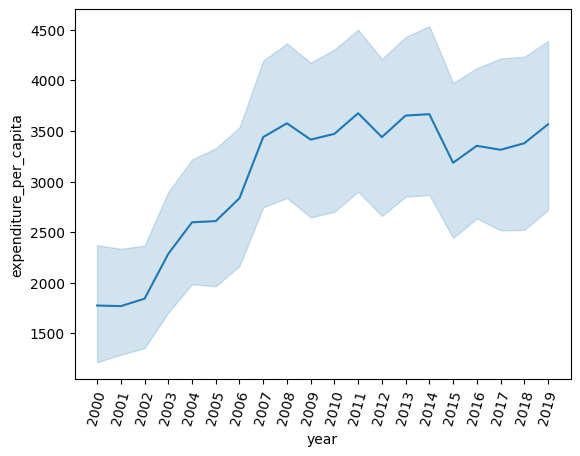

In [16]:
sns.lineplot(data = main_df, x = 'year', y = 'expenditure_per_capita');
plt.xticks(np.arange(min(main_df['year']), max(main_df['year'])+1, 1))
plt.xticks(rotation=75)
plt.show()

There is a steady increase in healthcare expenditure per capita from 2000 to around 2007, after which the growth rate stabilizes. A slight dip is observed during 2008–2009, likely reflecting the impact of the global financial crisis.

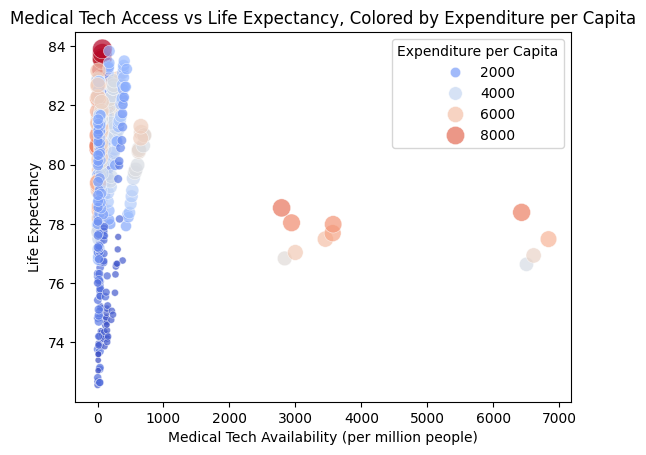

In [17]:
#Analyzes Medical Tech Access against Life Expectancy using the gradient of Healthcare Expernditure per Capita
sns.scatterplot(
    data=main_df,
    x='med_tech_availability_p_mil_ppl', 
    y='life_expectancy', 
    hue='expenditure_per_capita', 
    palette='coolwarm', 
    size='expenditure_per_capita', 
    sizes=(20, 200),
    alpha=0.7
)
plt.title("Medical Tech Access vs Life Expectancy, Colored by Expenditure per Capita")
plt.xlabel("Medical Tech Availability (per million people)")
plt.ylabel("Life Expectancy")
plt.legend(title="Expenditure per Capita")
plt.show()

This scatter plot compares life expectancy to medical technology availability, with dots colored by expenditure per capita. Higher expenditures are represented by warmer colors (orange/red). You can see an overall positive correlation between medical technology availability and life expectancy. Countries with higher levels of medical technology tend to have higher life expectancies. There is a cluster of outliers with low medical tech availability and high life expectancy. Countries with higher medical tech availability generally have higher life expectancy.


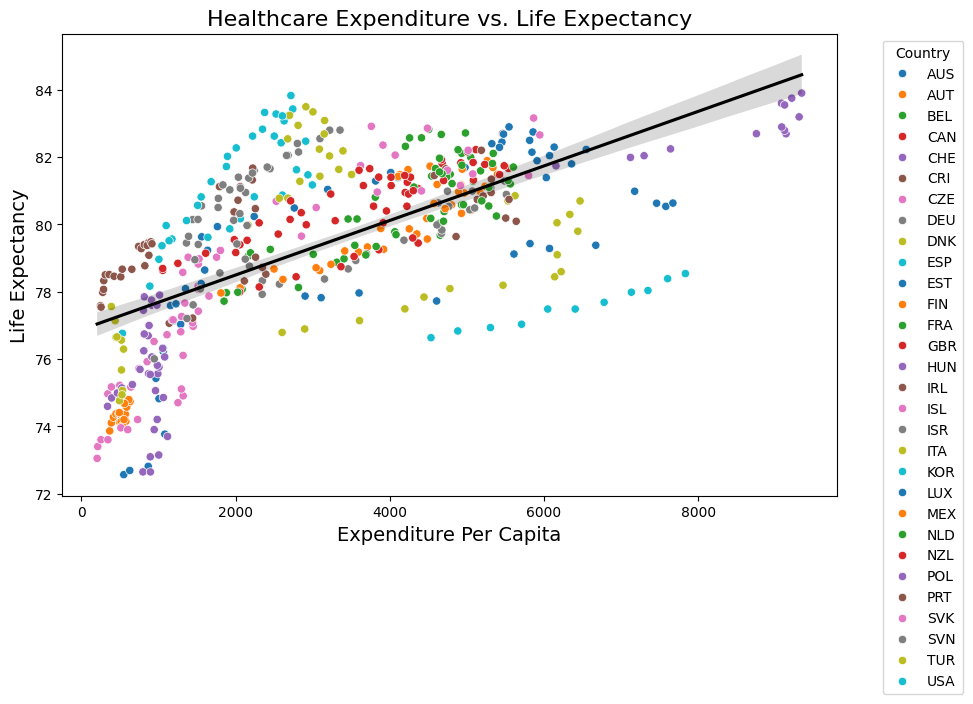

In [18]:
# correlation between life expectancy and health expenditure by capita
def per_capita_life_exp():
    df = pd.read_csv("cleaned_datasets/main_df.csv")
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df, x='expenditure_per_capita', y='life_expectancy', hue='code', palette='tab10')
    sns.regplot(data=df, x='expenditure_per_capita', y='life_expectancy', scatter=False, color='black')
    plt.title('Healthcare Expenditure vs. Life Expectancy', fontsize=16)
    plt.xlabel('Expenditure Per Capita', fontsize=14)
    plt.ylabel('Life Expectancy', fontsize=14)
    plt.legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()
per_capita_life_exp()

This scatter plot visualizes the relationship between healthcare expenditure per capita and life expectancy, with points color-coded by country. A trend line highlights the overall positive correlation. A clear positive correlation exists between healthcare expenditure and life expectancy. Several countries achieve comparable life expectancy at lower expenditure levels, which shows efficiency in healthcare systems. Countries like the United States, with high expenditure but relatively lower life expectancy, indicate inefficiencies/disparities in healthcare delivery. Overall, higher healthcare spending generally corresponds with improved life expectancy.

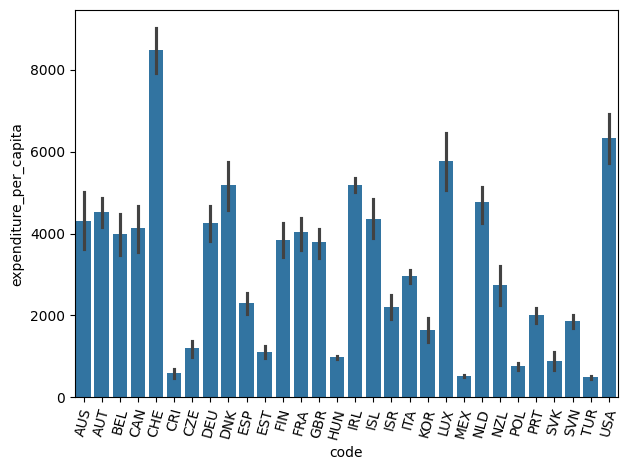

In [19]:
# expenditure per capita by country (mean over the years)
def expenditure_per_capita_by_country():
    df = pd.read_csv("cleaned_datasets/main_df.csv")
    sns.barplot(data = df, x = 'code', y = 'expenditure_per_capita');
    plt.xticks(rotation=75)
    plt.tight_layout()
    plt.show()

expenditure_per_capita_by_country()

The bar graph presents the expenditure per capita for various countries. The x-axis shows the country codes and the y-axis represents the expenditure per capita. Switzerland (CHE) has the highest healthcare expenditure per capita, while Turkey (TUR) has the lowest. The large variance in the data shows that I will be analyzing very different situations across countries. Having this variance could be useful in generalizing the results of this analysis to other countries, as it will provide insights into a large variety of healthcare expenditure sttrategies.

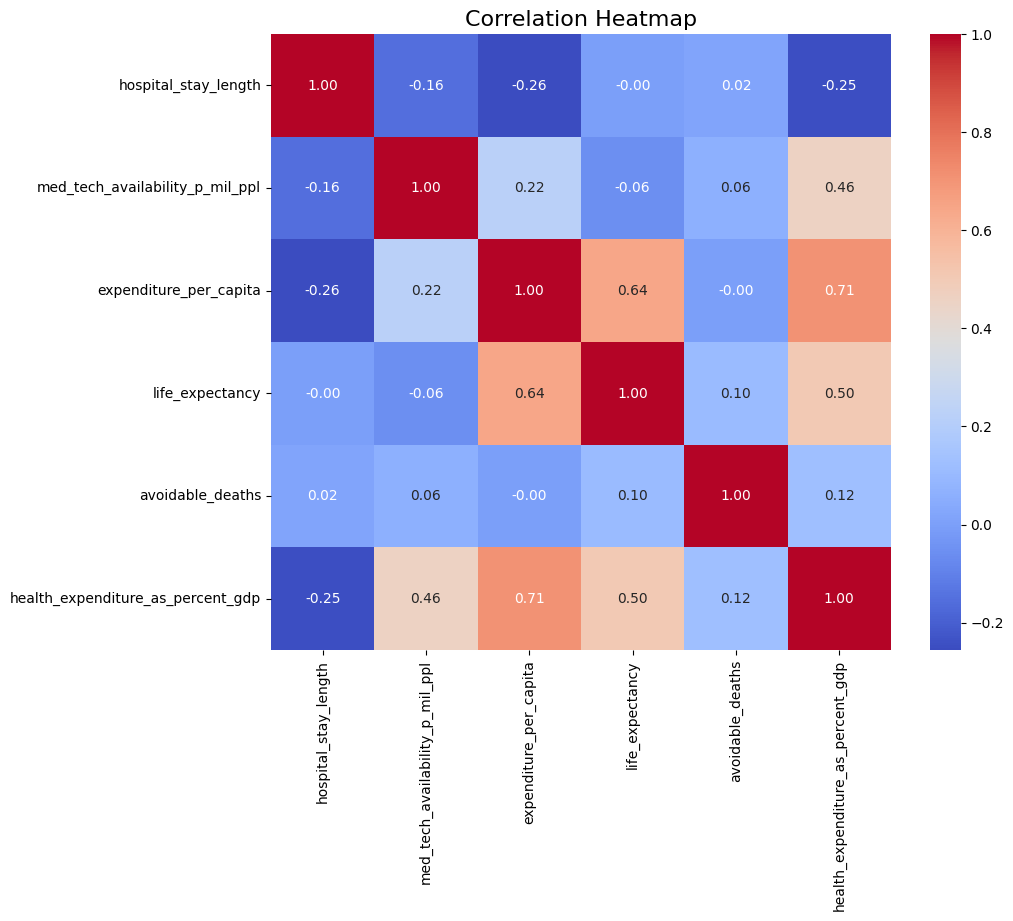

In [20]:
# correlation heat map for all variables
def heat_map_all_var():
    df = pd.read_csv("cleaned_datasets/main_df.csv")
    plt.figure(figsize=(10, 8))
    correlation_matrix = df[['hospital_stay_length', 'med_tech_availability_p_mil_ppl',
                                    'expenditure_per_capita', 'life_expectancy',
                                    'avoidable_deaths', 'health_expenditure_as_percent_gdp']].corr()

    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('Correlation Heatmap', fontsize=16)
    plt.show()
    
heat_map_all_var()

 This correlation heatmap depicts the relationships between our healthcare variables. Positive correlations exist between expenditure per capita and life expectancy, suggesting that increased investment in healthcare can lead to better health (life expectancy) outcomes. Additionally, countries with greater availability of medical technology tend to allocate more resources to healthcare. On the other hand, longer hospital stays appear to be associated with lower healthcare expenditures. This is what I'd would expect, as more healthcare resources would allow for lower wait times. One interesting value to note is the correlation between expenditure per capita and avoidable deaths appears to be 0. This is surprising, as it would suggest that a change in healthcare per person does not seem to change the number of avoidable deaths. In other words, increasing spending does not necessarily lead to more lives saved.

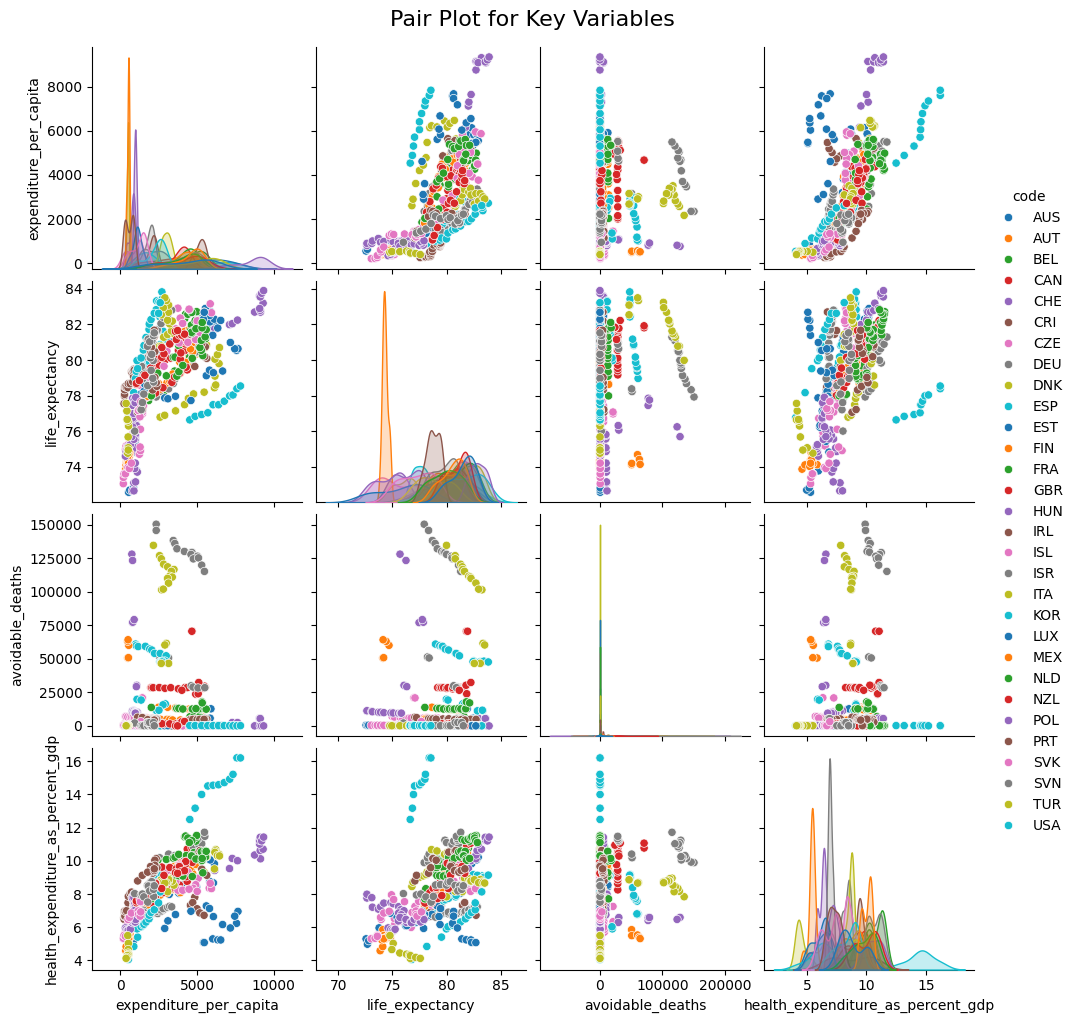

In [21]:
# key variables correlation plots
def key_variables_plot():
    df = pd.read_csv("cleaned_datasets/main_df.csv")
    sns.pairplot(df, vars=['expenditure_per_capita', 'life_expectancy', 
                                    'avoidable_deaths', 'health_expenditure_as_percent_gdp'],
                hue='code', palette='tab10', diag_kind='kde', height=2.5)
    plt.suptitle('Pair Plot for Key Variables', y=1.02, fontsize=16)
    plt.show()
    
key_variables_plot()

The pair plot provides a visual overview of the relationships between key healthcare variables. Like in the heat map, you can see that positive correlations are observed between expenditure per capita and life expectancy, suggesting that increased healthcare spending can lead to improved health outcomes. Additionally, there is a negative correlation between avoidable deaths and healthcare expenditure, indicating that countries with higher spending may have fewer preventable deaths. The scatter plot allows us to see that many variables do not increase in a linear pattern with expenditure per capita, so I want to try out some nonlinear models in the future when trying to discern patterns between healthcare expenditure and other quality of care variables.

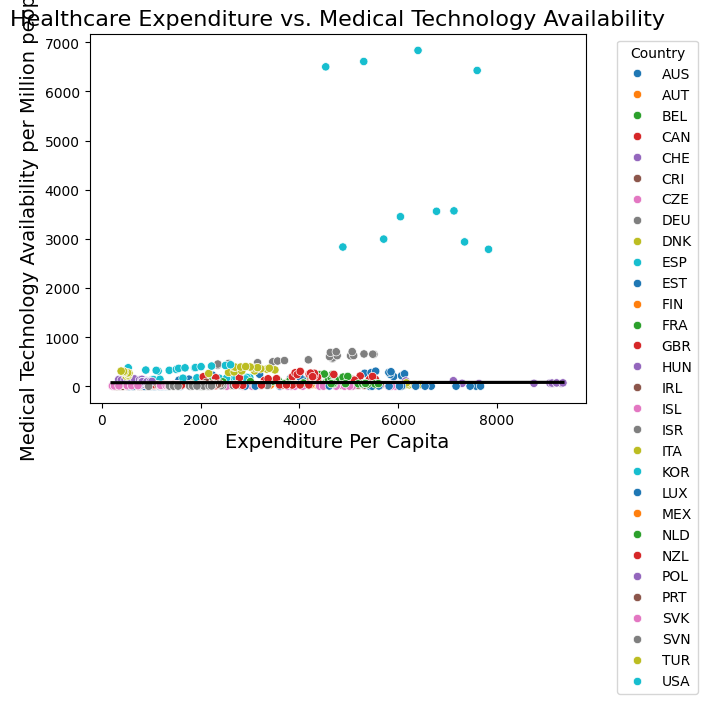

In [22]:
def per_capita_med_tech_availability(df):
    sns.scatterplot(data=df, x='expenditure_per_capita', y='med_tech_availability_p_mil_ppl', hue='code', palette='tab10')
    sns.regplot(data=df, x='expenditure_per_capita', y='life_expectancy', scatter=False, color='black')
    plt.title('Healthcare Expenditure vs. Medical Technology Availability', fontsize=16)
    plt.xlabel('Expenditure Per Capita', fontsize=14)
    plt.ylabel('Medical Technology Availability per Million people', fontsize=14)
    plt.legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()
per_capita_med_tech_availability(main_df)

The scatter plot visualizes the relationship between healthcare expenditure per capita and medical technology availability per million people across various countries. While there is a general trend suggesting that countries with higher expenditure per capita tend to have higher medical technology availability, it is not very strong, and I concluded that there is no strong correlation. There is too much variation among countries, with some countries having high expenditure but relatively low technology availability, and vice versa. Furthermore, the trend is almost flat, meaning that not only is there not a strong correlation, but there is also a very small effect. This demonstrates that healthcare expenditure per capita is not a good indicator of medical technological availability.

# Results

First, I created a function to get the ranking of each considered variable for each country, where 1 is considered the best. The function also calculates the mean value and standard deviation for each variable for determining the weights of the weighted average.

In [23]:

df = pd.read_csv("cleaned_datasets/main_df.csv")

new = df.groupby('code').mean()
new = new.drop(columns = ['year'])

def rank_column(column,ascending):
    """ Rank each country in the dataframe by a specified column. 
    Return a dictionary containing a new dataframe with rank, code, and that column, as well as the mean and standard deviation of that column to be used in a weighted average later.
    """
    rank = new.sort_values(column,ascending = ascending)
    rank = rank.reset_index()
    rank['rank'] = rank.index+1
    mean_col_value = rank[column].mean()
    sd_col = rank[column].std()
    rank = rank[['rank','code',column]]
    return {'rank_df':rank, 'mean':mean_col_value, 'sd':sd_col}


quality_of_care_info = {
    # lowest stay should be ranked 1st --> ascending = True
    'hospital_stay_length':rank_column('hospital_stay_length', True),
    # lowest technology availability should be ranked lowest --> ascending = False
    'med_tech_availability_p_mil_ppl':rank_column('med_tech_availability_p_mil_ppl', False),
    # lowest life expectancy should be ranked lowest --> ascending = False
    'life_expectancy':rank_column('life_expectancy', False),
    # lowest avoidable deaths should be ranked 1st --> ascending = True
    'avoidable_deaths':rank_column("avoidable_deaths", True)
}
[hos_stay, med_ava, life_exp, avoidable_death] = [data['rank_df'] for data in quality_of_care_info.values()]

Let's look at the ranking for average hospital stay length.

In [24]:
hos_stay

,rank,code,hospital_stay_length
0,1,TUR,4.840919
1,2,USA,4.902914
2,3,MEX,5.791359
3,4,AUS,5.834104
4,5,ISL,5.995304
5,6,DNK,6.021870
6,7,FRA,6.249538
7,8,NLD,6.292490
8,9,BEL,7.102853
9,10,EST,7.182899


Let's look at the ranking for medical technology availability.

In [37]:
med_ava

,rank,code,med_tech_availability_p_mil_ppl
0,1,USA,4411.432403
1,2,DEU,582.332938
2,3,KOR,373.892966
3,4,ITA,354.161266
4,5,TUR,267.589750
5,6,GBR,223.100559
6,7,AUS,219.910325
7,8,ESP,163.913162
8,9,FRA,158.771804
9,10,CAN,127.790928


Let's look at the ranking for life expectancy.

In [38]:
life_exp

,rank,code,life_expectancy
0,1,CHE,82.855535
1,2,ITA,82.071019
2,3,ISL,81.677044
3,4,ESP,81.572683
4,5,AUS,81.467908
5,6,FRA,81.256463
6,7,ISR,81.148171
7,8,IRL,81.133208
8,9,CAN,80.932003
9,10,KOR,80.835540


Let's look at the ranking for avoidable deaths.

In [39]:
avoidable_death

,rank,code,avoidable_deaths
0,1,ISL,74.005882
1,2,LUX,141.376471
2,3,TUR,146.630000
3,4,FRA,182.945000
4,5,USA,209.209091
5,6,DNK,230.306250
6,7,CRI,311.165000
7,8,SVK,579.150000
8,9,ISR,637.200000
9,10,EST,638.566667


Next, I calculated the ranking of each country as a combination of all variables by taking a weighted average. 

In [41]:
def weight_averages(multipliers_dict):
    columns = ['code','rank']
    # get dataframes ready to be merged, only including the code and rank columns
    df_pair_1 = [hos_stay[columns], med_ava[columns]]
    df_pair_2 = [life_exp[columns],avoidable_death[columns]]
    # merge all 4 dataframes into one, with columns such as "rank_hospital_stay_length"
    rank_df_1 = pd.merge(df_pair_1[0],df_pair_1[1], on = "code", suffixes = ['_hospital_stay_length','_med_tech_availability_p_mil_ppl'])
    rank_df_2 = pd.merge(df_pair_2[0],df_pair_2[1], on = "code", suffixes = ['_life_expectancy','_avoidable_deaths'])
    rank_df = pd.merge(rank_df_1,rank_df_2, on = "code")
    # calculated the weighted average based on the passed in normalized multipliers dict
    rank_df['rank_weighted_avg'] = 0
    for column,multiplier in multipliers_dict.items():
        temp = rank_df[column] * multiplier
        rank_df["rank_weighted_avg"] = rank_df["rank_weighted_avg"] + temp

    return rank_df

In order to get the weighted average of the columns, I must first define how to weight them. Here, I chose to weight the ranks based on the variability of each column. Variables that have a very low variability will be weighted less, since the difference in rank accounts for little difference in metric values. Columns with higher variability get weighted more heavily, as difference in rank correlates much more strongly with difference in metric values. Here, I define variabilility as what percent the standard deviation is of the mean. In other words, how much the data varies proportionally.

In [42]:
def weight_by_sd_as_perc_mean(quality_of_care_dict):
    """Determine the weights based on standard deviation as a percent of mean, all normalized
    """
    # calculate unnormalized weights
    weights_dict = {}
    for title, stats in quality_of_care_dict.items():
        rank_title = 'rank_' + title
        sd_as_perc_mean = 100 * stats['sd']/stats['mean']
        weights_dict[rank_title] = sd_as_perc_mean
    # normalize weights so they can be used as multipliers in a weighted average
    total_weight = sum(weights_dict.values())
    weights_dict = {title: weight/total_weight for title, weight in weights_dict.items()}
    return weights_dict

Now, let's try analyzing with weighted and unweighted averages to see how each one affects the results, and if there are any differences.

In [43]:
def calculate_results(multipliers):
    """Given a dictionary of column names and multipliers, calculate the weighted average.
    Return a dataframe containing the final rank, code, and the weighted average of all ranked variables.
    """
    rank_df = weight_averages(multipliers)
    results_df = rank_df.sort_values("rank_weighted_avg",ascending = True)
    # get the rank column
    results_df = results_df.reset_index(drop = True)
    results_df["rank"] = results_df.index + 1
    # keep only the necessary columns
    results_df = results_df[["rank", "code", "rank_weighted_avg"]]
    return results_df

In [44]:
# get the keys for the multipliers dictionaries
rank_titles = ['rank_' + title for title in quality_of_care_info.keys()]
# get weighted and unweighted multipliers
unweighted_multipliers = dict(zip(rank_titles, [0.25]*4))
weighted_multipliers = weight_by_sd_as_perc_mean(quality_of_care_info)

# calculate results based on the different multipliers
results_unweighted = calculate_results(weighted_multipliers)
results_weighted = calculate_results(weighted_multipliers)

Let's see the results

In [45]:
results_unweighted

,rank,code,rank_weighted_avg
0,1,USA,2.647390
1,2,TUR,4.153010
2,3,FRA,7.031112
3,4,KOR,9.705076
4,5,AUS,10.133992
5,6,GBR,10.544358
6,7,BEL,12.999676
7,8,ITA,13.640448
8,9,DEU,13.682998
9,10,CHE,13.807832


In [46]:
results_weighted

,rank,code,rank_weighted_avg
0,1,USA,2.647390
1,2,TUR,4.153010
2,3,FRA,7.031112
3,4,KOR,9.705076
4,5,AUS,10.133992
5,6,GBR,10.544358
6,7,BEL,12.999676
7,8,ITA,13.640448
8,9,DEU,13.682998
9,10,CHE,13.807832


Now let's get the ranking of each country's expenditure.

In [47]:
gdp_expenditure = rank_column("health_expenditure_as_percent_gdp", False)['rank_df']
capita_expenditure = rank_column('expenditure_per_capita', False)['rank_df']

In [48]:
gdp_expenditure

,rank,code,health_expenditure_as_percent_gdp
0,1,USA,14.592818
1,2,FRA,10.775200
2,3,DEU,10.713600
3,4,CHE,10.549923
4,5,AUT,10.018556
5,6,CAN,9.970737
6,7,NLD,9.781412
7,8,BEL,9.779842
8,9,DNK,9.717750
9,10,PRT,9.483462


In [49]:
capita_expenditure

,rank,code,expenditure_per_capita
0,1,CHE,8489.708045
1,2,USA,6325.002663
2,3,LUX,5770.764706
3,4,DNK,5192.812500
4,5,IRL,5190.936674
5,6,NLD,4769.588235
6,7,AUT,4537.166667
7,8,ISL,4346.294118
8,9,AUS,4316.530909
9,10,DEU,4246.079065


Now let's see if there is any correlation of a country's quality of healthcare and their healthcare expenditure by comparing the two rankings in a scatter plot. 

In [50]:
def care_quality_vs_expenditure(results_df, expenditure_rank_df, metric_title, graph_suffix):
    merged_df = pd.merge(results_df, expenditure_rank_df, on=['code'], suffixes=["_final", "_health_expenditure"])
    x = merged_df['rank_health_expenditure'] # get the rank of health expenditure as specified 
    y = merged_df['rank_final'] # get the quality final rank
    
    # create and fit regression model
    slope, intercept, r_value, _, _ = linregress(x, y)
    line = slope * np.array(x) + intercept  # predicted values
    r_squared = r_value**2  # calculate R^2
    
    # plot
    plt.figure(figsize=(10, 6))
    plt.title(f"Rank of {metric_title} vs HealthCare Quality Rank {graph_suffix}")
    sns.scatterplot(data=merged_df, y='rank_final', x='rank_health_expenditure', label="Data Points")
    plt.plot(x, line, color='red', label=f"Fit: y={slope:.2f}x + {intercept:.2f}")
    
    # show R^2 on graph
    plt.text(min(x), max(y), f"$R^2$ = {r_squared:.2f}", fontsize=12, color="green")
    
    # arrange labels and legend
    plt.xlabel("Expenditure as a Percentage of GDP")
    plt.ylabel("Care Quality Rank")
    plt.legend()
    plt.grid()
    plt.show()


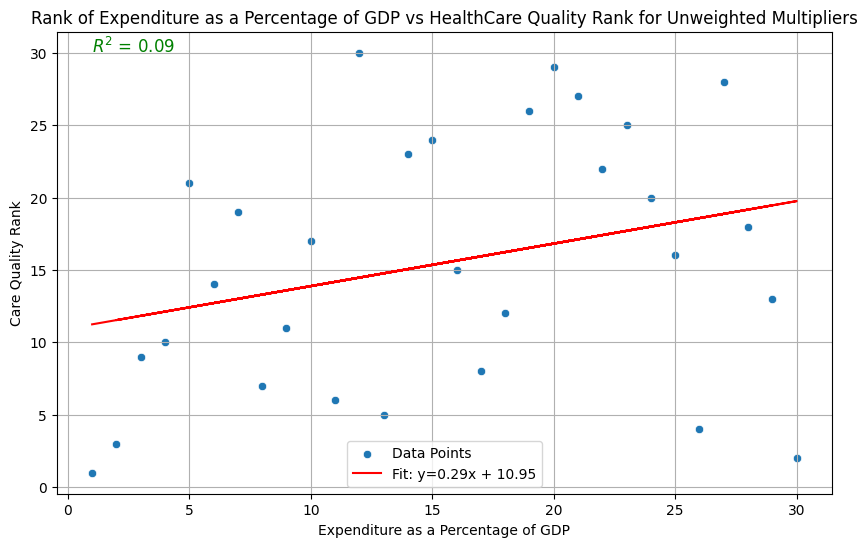

In [51]:
care_quality_vs_expenditure(results_unweighted, gdp_expenditure, 
                            "Expenditure as a Percentage of GDP", "for Unweighted Multipliers")

The R<sup>2</sup> for this line was 0.09, which is very low. Based on the graph and the R<sup>2</sup> value, it looks like there's no significant correlation between the quality of healthcare and the healthcare expenditure as a percentage of GDP for the unweighted averages. A high correlation would look like a diagonal line from (0,0) to (30,30) with a tight spread, indicating that the rank for healthcare expenditure corresponds with the rank for quality of care.

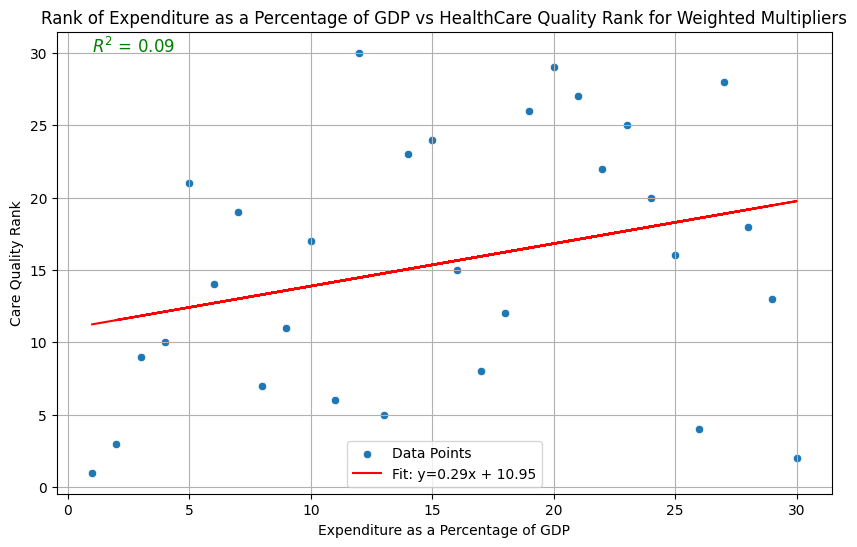

In [55]:
care_quality_vs_expenditure(results_weighted, gdp_expenditure, 
                            "Expenditure as a Percentage of GDP", "for Weighted Multipliers")

Looking at the comparison of the ranking for healthcare expenditure as a percentage of GDP and the ranking of quality of care based on the weighted averages, it seems to be a similar picture to the unweighted averages with the same R<sup>2</sup> score of 0.09. We, again, do not see a significant correlation based on the scatter plot; from just the rank for healthcare expenditure, you would not be able to accurately predict the final quality of care ranking.

Now let's see the results for healthcare expenditure per capita rankings versus the quality of care rankings based on a weighted and unweighted average.

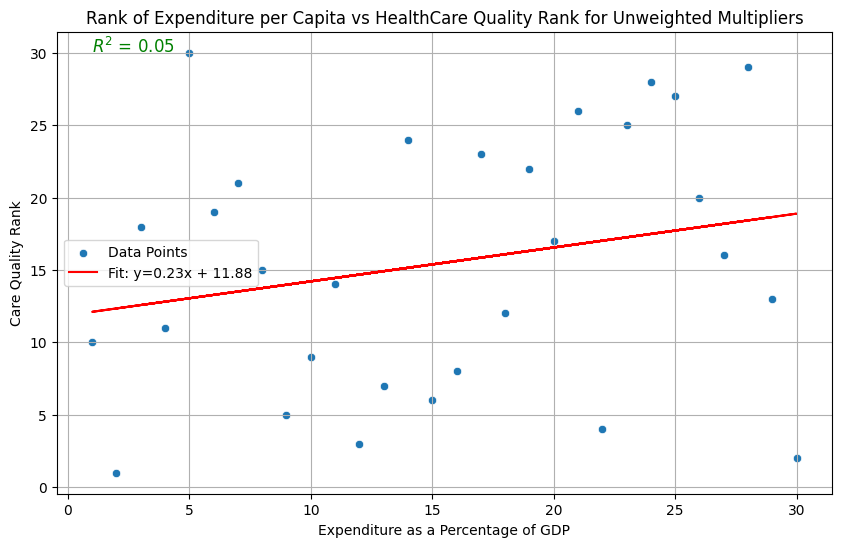

In [56]:
care_quality_vs_expenditure(results_unweighted, capita_expenditure, 
                            "Expenditure per Capita", "for Unweighted Multipliers")

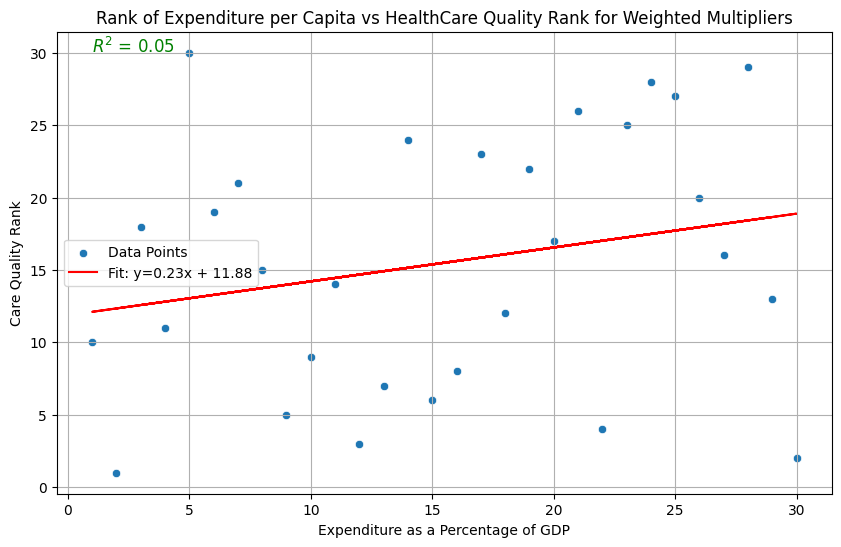

In [57]:
care_quality_vs_expenditure(results_weighted, capita_expenditure, 
                            "Expenditure per Capita", "for Weighted Multipliers")

Based on the even lower scores of R<sup>2</sup> (0.05) and the graphs, it also looks like there is no correlation between healthcare quality and healthcare expenditure per capita for the ranks based on neither the unweighted average nor the weighted average of other metric rankings. 

Based on the four plots and their R<sup>2</sup> scores, there is not sufficient evidence to support out hypothesis for healthcare expenditure resulting in a large impact on quality of care by our definition of quality of care (a combination of life expectancy, average hospital stay length, proportional medical technology availability and avoidable deaths). 

# Discussion and Conclusion

This analysis aimed to explore the relationship between healthcare quality (as defined by our chosen variables) and expenditure among OECD (Organization for Economic Co-operation and Development) countries, given their more stable economies compared to less developed nations, from 2000 to 2019. I looked at many categories to assess healthcare systems, utilizing metrics such as hospital stay lengths, medical technology availability, life expectancy, and avoidable deaths to construct a comprehensive healthcare quality index. This method involved ranking individual variables and then combining them with weighted and unweighted averages to determine an overall rank for each country. By comparing these quality rankings with healthcare expenditure—both as a percentage of GDP and per capita—I aimed to uncover potential links between government spending on healthcare and health outcomes. However, it is important to note that “healthcare quality” is a broad term, defined differently across sources, including the ones referenced in the Background and Prior Work section.

Our exploratory data analysis (EDA) revealed a positive correlation between healthcare expenditure per capita and life expectancy at birth, however, life expectancy is confounded by a country's wealth, as quality of life would likely have a greater impact on life expectancy than healthcare quality. Higher quality of life could lead to healthier lifestyles that have a lesser need for healthcare systems. Therefore I cannot claim that healthcare expenditure increases life expectancy. However, the correlations between healthcare expenditure and other metrics, such as preventable deaths, hospital stay lengths, and access to medical technology, were weaker or inconclusive. This indicates that while spending is a crucial factor in healthcare quality, it is not the sole determinant of outcomes in these areas.

The results suggest that higher healthcare expenditure does not necessarily correlate with better healthcare quality overall for the variables considered in this analysis. For example, the United States ranked highest in healthcare quality along with having significantly high spending, both as a percentage of GDP and per capita. Conversely, Turkey achieved a strong rank in healthcare quality as well, but while being the lowest in expenditure in both percentage of GDP and per capita. Countries like Germany and Switzerland, which allocate substantial portions of their GDP to healthcare, did not achieve top rankings in quality. This emphasizes the point that simply increasing financial resources does not guarantee better outcomes, highlighting the importance of evaluating healthcare systems from perspectives that extend beyond financial investment, such as focusing on how resources are allocated and the effectiveness of healthcare services.

Additionally, countries such as France, which spend less per capita but allocate a higher percentage of their GDP to healthcare, ranked highly. This suggests that these nations may be prioritizing healthcare relative to their economic output rather than focusing solely on the total amount of expenditure. It indicates that the overall investment in healthcare, as a proportion of GDP, could play a more significant role in determining healthcare quality and outcomes than per capita spending alone. As such, this underscores the importance of considering broader economic factors and systemic policies when evaluating healthcare systems.

In conclusion, our hypothesis was not fully supported, and further exploration is needed to understand the complex relationship between healthcare expenditure and healthcare quality. This aligns with the Background and Prior Work research that was conducted as well, as only some sources were able to find strong correlations, while others were not. 